In [ ]:
# Data processing
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Path configuration for custom module imports  
# -----------------------------------------------------------------------
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings  
warnings.filterwarnings("ignore") 

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_regression import RegressionModels


In [98]:
df = pd.read_csv('../data/output/api_rent_madrid_preprocessed.csv', index_col=0).reset_index(drop=True)
df.head()

,price,size,exterior,rooms,bathrooms,distance,municipality,province,hasLift,numPhotos,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,floor
0,550.0,8.442463,False,4.410093,3,1.048670,657.095509,579.687729,661.431099,1.152172,1.0,0.0,0.0,0.0,0.0,0.0,13.0
1,750.0,-0.221149,True,-0.712507,1,-0.896578,705.594108,693.233618,677.631111,-1.021827,0.0,0.0,0.0,1.0,0.0,0.0,6.0
2,750.0,0.057424,True,0.312013,1,-0.360972,685.520603,693.233618,670.210811,-0.090113,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,400.0,-0.026148,True,0.312013,2,1.926351,637.579238,693.233618,670.210811,0.634554,0.0,0.0,0.0,0.0,1.0,0.0,5.0
4,450.0,0.586712,False,0.312013,1,1.464429,644.084662,579.687729,677.631111,0.013411,0.0,0.0,0.0,1.0,0.0,0.0,5.0


---

In [79]:
params_rf = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': range(5, 15),
    'min_samples_leaf': range(1, 10),
    'max_leaf_nodes': range(5, 51, 5)
}

res = model1.model_fit("random_forest", params_rf)
model1.get_results()
model1.get_metrics("random_forest").round(2)

,R2,MAE,RMSE
train,0.83,27.31,35.96
test,0.59,36.27,46.82


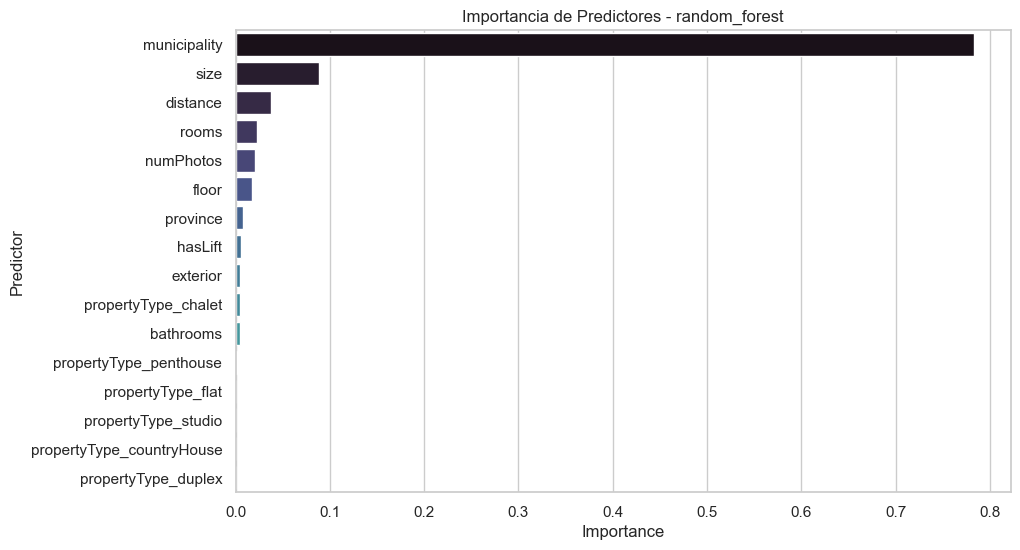

,Predictor,Importance
5,municipality,0.782448
0,size,0.088932
4,distance,0.037304
2,rooms,0.022927
8,numPhotos,0.020887
15,floor,0.017347
6,province,0.008422
7,hasLift,0.005681
1,exterior,0.004807
9,propertyType_chalet,0.004635


In [80]:
model1.predictors_importance('random_forest')

---

In [82]:
params_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model1.model_fit("gradient_boosting", params_gb)
model1.get_results()
model1.get_metrics("gradient_boosting").round(2)

,R2,MAE,RMSE
train,0.84,26.68,34.77
test,0.58,35.36,47.52


In [83]:
model1.plot_actual_vs_prediction('gradient_boosting')

TypeError: RegressionModels.get_metrics() takes 2 positional arguments but 3 were given